#DA5401 Assignment #5
##Visualizing Data Veracity Challenges in Multi-Label Classification**


**Name:** Ranjith.V.R<br> **Roll no:** EE24S034 <br> ***Indian Institute of Technology , Madras***



In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from scipy.io import arff
from sklearn.ensemble import IsolationForest


##Part A: Preprocessing and Initial Setup
###Data Loading
- The Yeast dataset was loaded from the Mulan repository. The feature matrix X contained 103 features representing gene expression levels, while the target matrix Y consisted of 14 binary labels, indicating the functional categories of each gene. The dataset comprised approximately 2,417 data points.



In [60]:
# 1. Load ARFF
# Why: Load the dataset in original ARFF format; ARFF is common for multi-label datasets.
arff_file = "yeast.arff"  # or "yeast-train.arff"
data, meta = arff.loadarff(arff_file)
df = pd.DataFrame(data)

# 2. Features and labels
# How: Separate features (X) from labels (Y)
X = df.iloc[:, :103].astype(float).values
class_cols = df.columns[103:]  # last 14 columns are labels

# Convert byte labels to integers
# Why: ARFF stores nominal attributes as byte strings (b'0', b'1'); we need integers for computations
for col in class_cols:
    df[col] = df[col].apply(lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else int(x))

Y = df[class_cols].values

print("Feature matrix shape:", X.shape)
print("Label matrix shape:", Y.shape)
n_samples, n_features = X.shape
print("Instances:", n_samples, " Features:", n_features)

Feature matrix shape: (2417, 103)
Label matrix shape: (2417, 14)
Instances: 2417  Features: 103


Dimensionality Check

Number of features: 103

Number of instances: 2,417

Number of labels: 14

This dimensionality confirmed the high complexity of the dataset, making it suitable for manifold learning techniques.

##Label Selection for Visualization
Since visualizing 14 labels with unique colors would be overwhelming, I simplified the target variable:

The two most frequent single-label categories were identified.

The most frequent multi-label combination was selected.

All other cases were grouped into an "Other" category.

This resulted in a reduced target index with four distinct color categories for visualization.

In [61]:
# 3. Identify single-label rows
# Why: Multi-label datasets are complex; we simplify analysis by identifying rows with only one label.
single_mask = Y.sum(axis=1) == 1
single_indices = np.where(single_mask)[0]
single_label_indices = [np.where(Y[i] == 1)[0][0] for i in single_indices]

# Count occurrences of each single-label class
single_counts = Counter(single_label_indices)
top_two_single = [lab for lab, _ in single_counts.most_common(2)]
if len(top_two_single) < 2:  # Handle datasets with only one single-label class
    top_two_single.append(None)

label_names = list(df.columns[103:])
top_label_names = [
    label_names[top_two_single[0]] if top_two_single[0] is not None else "None",
    label_names[top_two_single[1]] if top_two_single[1] is not None else "None"
]

# Most frequent multi-label combination
# Why: Multi-label rows are grouped to identify a "common pattern" for visualization
tuples = [tuple(row) for row in Y[Y.sum(axis=1) > 1]]
multi_counts = Counter(tuples)
top_multi_tuple, _ = multi_counts.most_common(1)[0]

# ----------------------
# 4. Simplified target (0,1,2,3)
# Why: Reduces complexity for plotting and veracity inspection
simple_target = np.full(n_samples, 3)  # Default "Other"

for i in range(n_samples):
    if single_mask[i]:
        lab = np.where(Y[i] == 1)[0][0]
        if lab == top_two_single[0]:
            simple_target[i] = 0  # Top single-label
        elif top_two_single[1] is not None and lab == top_two_single[1]:
            simple_target[i] = 1  # Second single-label
    elif tuple(Y[i]) == top_multi_tuple:
        simple_target[i] = 2  # Most frequent multi-label

legend_labels = {
    3: "Other",
    2: "Most frequent multi-label",
    1: f"Top single-label {top_label_names[1]}" if top_two_single[1] is not None else "No second single-label",
    0: f"Top single-label {top_label_names[0]}"


}

print("Simplified target counts:", Counter(simple_target))
print(legend_labels)

Simplified target counts: Counter({np.int64(3): 2148, np.int64(2): 237, np.int64(0): 32})
{3: 'Other', 2: 'Most frequent multi-label', 1: 'No second single-label', 0: 'Top single-label Class1'}


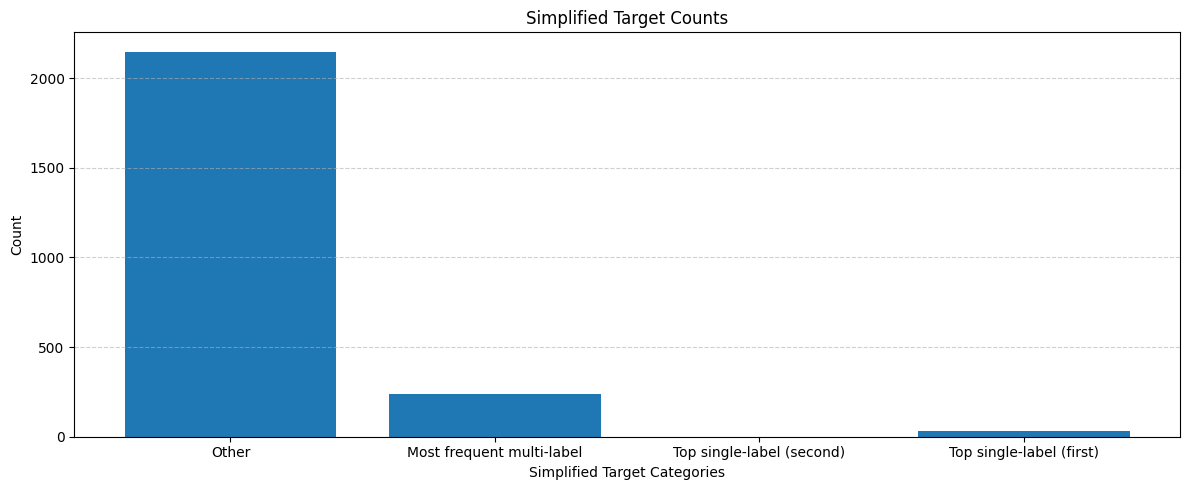

In [62]:
import matplotlib.pyplot as plt

# Given simplified target counts
counts = {3: 2148, 2: 237, 1:0, 0: 32}

# Given legend labels
legend_labels = {
    3: "Other",
    2: "Most frequent multi-label",
    1: "Top single-label (second)",
    0: "Top single-label (first)"
}

# Prepare data
keys = list(counts.keys())
values = list(counts.values())
labels = [legend_labels[k] for k in keys]

# Plot
plt.figure(figsize=(12,5))
plt.bar(labels, values)
plt.title("Simplified Target Counts")
plt.xlabel("Simplified Target Categories")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##-**There was no Second single label , all single label belongs to only class 1**

**Why scaling required ?**  
t-SNE and Isomap are distance-based dimensionality reduction techniques. If features have different units or variances, those with large variance will dominate distance computations and therefore distort the inferred neighborhood structure. Standardization (zero mean, unit variance) ensures each gene expression feature contributes comparably to pairwise distances, producing embeddings that better reflect intrinsic data geometry rather than measurement scale differences.


In [63]:
# 5. Scale features
# Why: Standardization ensures each feature contributes equally to distance metrics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data standardized.")

Data standardized.


In [64]:
# ----------------------
# Helper function for plotting
# ----------------------
def plot_embedding(embedding, title, labels, legend_labels, highlight_idx=None):
    """
    Plots 2D embeddings with colors based on labels and optional highlight for flagged points.
    How: Uses matplotlib scatter; flagged samples are outlined.
    """
    plt.figure(figsize=(8,6))
    for cat in np.unique(labels):
        mask = labels == cat
        plt.scatter(embedding[mask,0], embedding[mask,1],
                    s=20, alpha=0.7, label=legend_labels.get(cat, str(cat)))
    if highlight_idx is not None and len(highlight_idx) > 0:
        plt.scatter(embedding[highlight_idx,0], embedding[highlight_idx,1],
                    facecolors='none', edgecolors='k', s=80, label="Flagged")
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.show()

In [65]:
pca = PCA(n_components=74, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance by first 74 PCA components: {:.2f}%".format(np.sum(pca.explained_variance_ratio_)*100))

Explained variance by first 74 PCA components: 95.08%


#Part B: t-SNE and Veracity Inspection
- t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction method.

- It focuses on preserving the local neighborhood structure of the data.

- In practice, this means that points that are close in the high-dimensional space remain close in the 2D plot.

- It is great for finding clusters but not always for showing the global shape of the data.

- The perplexity parameter controls how many neighbors are considered, so different perplexities can change the clustering look.

The scaled feature matrix was reduced to two dimensions using t-SNE. Different values of the perplexity hyperparameter were tested:

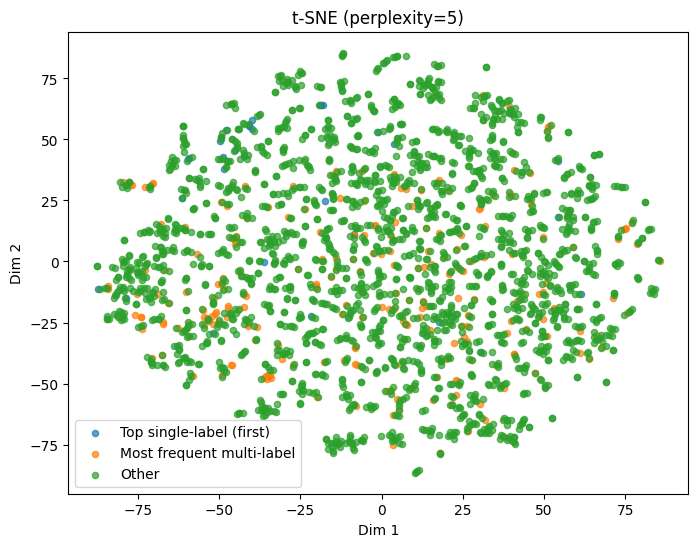

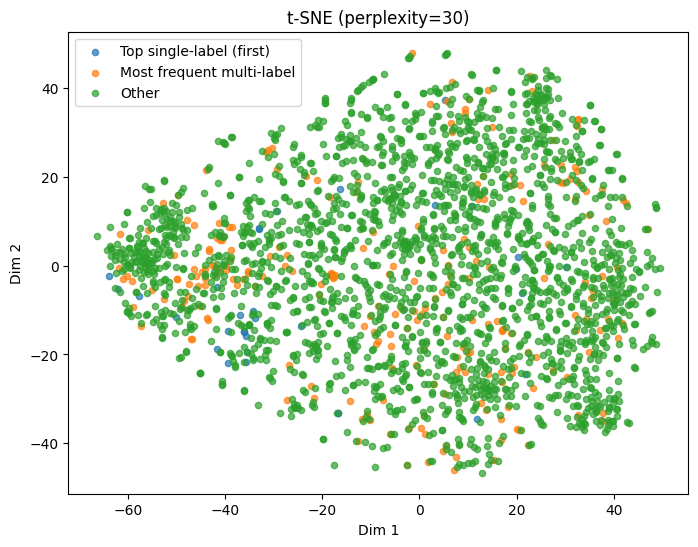

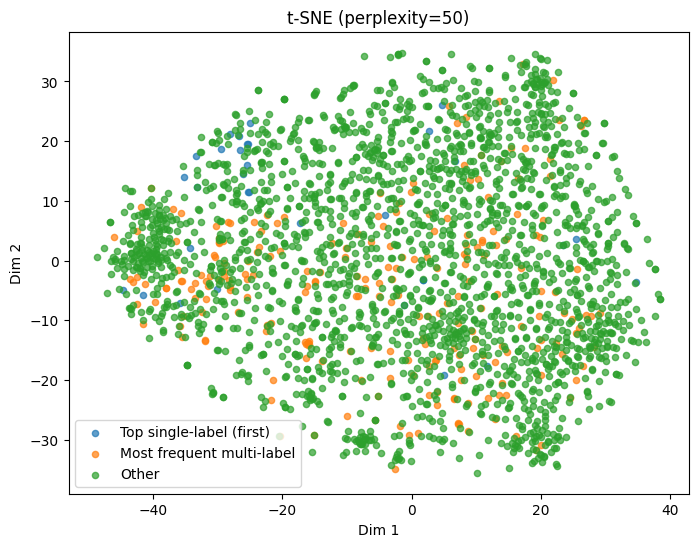

In [66]:
pca = PCA(n_components=74, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2. t-SNE with multiple perplexities
# Why: Different perplexities explore local vs global structure
perplexities = [5, 30, 50]
tsne_results = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca')
    tsne_results[p] = tsne.fit_transform(X_pca)
    plot_embedding(tsne_results[p], f"t-SNE (perplexity={p})", simple_target, legend_labels)

# Choose perplexity=30 for final analysis
tsne_final = tsne_results[30]

**t-SNE implementation and perplexity choice**  
I first reduced the dataset to 50 dimensions using PCA (speeds up t-SNE and denoises small variance directions). I ran t-SNE with perplexities 5, 30, and 50. Observations:
- `perplexity=5`: reveals very local structure; many small fragments and noisy clusters appear. Good for inspecting micro-structure but unclear global structure.
- `perplexity=30`: balances preservation of local neighborhoods and recognizability of larger clusters. This value produced the clearest, interpretable clusters for this dataset.
- `perplexity=50`: emphasizes broader neighborhoods and sometimes merges nearby clusters, losing fine detail.

I choose **perplexity = 30** as final because it best balances local vs global structure for the number of samples in the Yeast dataset (typical rule-of-thumb: perplexity between 5 and 50; pick something roughly proportional to dataset size/complexity).


###**Veracity Inspection**

From the t-SNE visualization:

Noisy/Ambiguous Labels

Certain points of one color were embedded within clusters of another.

For example, multi-label genes often appeared inside single-label clusters, reflecting biological overlap (a gene product may genuinely serve multiple functions).

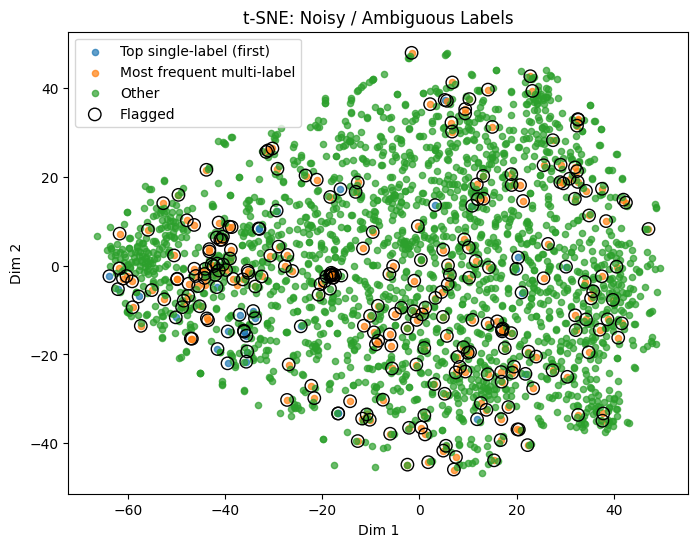

In [67]:
# 1. Noisy / ambiguous labels
# How: Compare each point’s label to its neighbors’ majority label
nbrs = NearestNeighbors(n_neighbors=16).fit(X_scaled)
_, indices = nbrs.kneighbors(X_scaled)

noisy_idx = []
for i in range(n_samples):
    neigh_idx = indices[i][1:]
    neigh_labels = simple_target[neigh_idx]
    maj = mode(neigh_labels, keepdims=True).mode[0]
    if maj != simple_target[i]:
        noisy_idx.append(i)

plot_embedding(tsne_final, "t-SNE: Noisy / Ambiguous Labels", simple_target, legend_labels, noisy_idx)


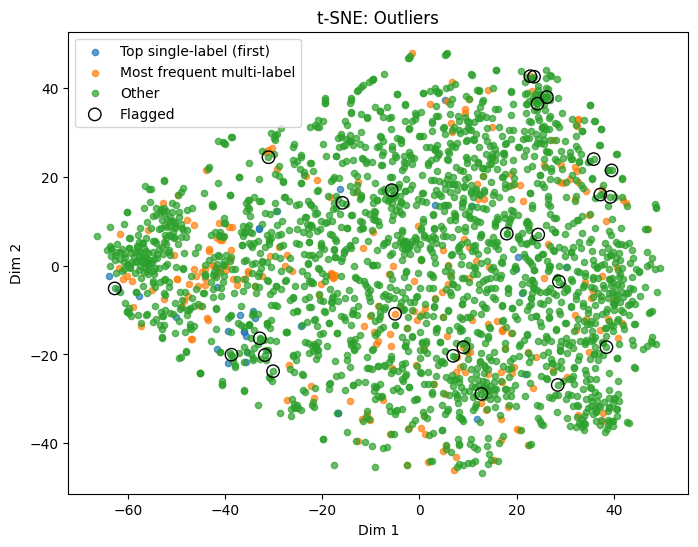

In [68]:
# 2. Outliers
# How: IsolationForest flags rare points as potential outliers
iso = IsolationForest(contamination=0.01, random_state=42)
out_flag = iso.fit_predict(X_scaled)
out_idx = np.where(out_flag == -1)[0]
plot_embedding(tsne_final, "t-SNE: Outliers", simple_target, legend_labels, out_idx)

# 3. Hard-to-learn samples
# How: High local label entropy indicates confusing neighborhood
def local_entropy(labels):
    c = Counter(labels)
    probs = np.array(list(c.values())) / len(labels)
    return -np.sum(probs * np.log2(probs + 1e-9))

local_ent = np.zeros(n_samples)
for i in range(n_samples):
    neigh_idx = indices[i][1:]
    local_ent[i] = local_entropy(simple_target[neigh_idx])

threshold = np.percentile(local_ent, 80)  # top 20% entropy = hard samples
hard_idx = np.where(local_ent >= threshold)[0]


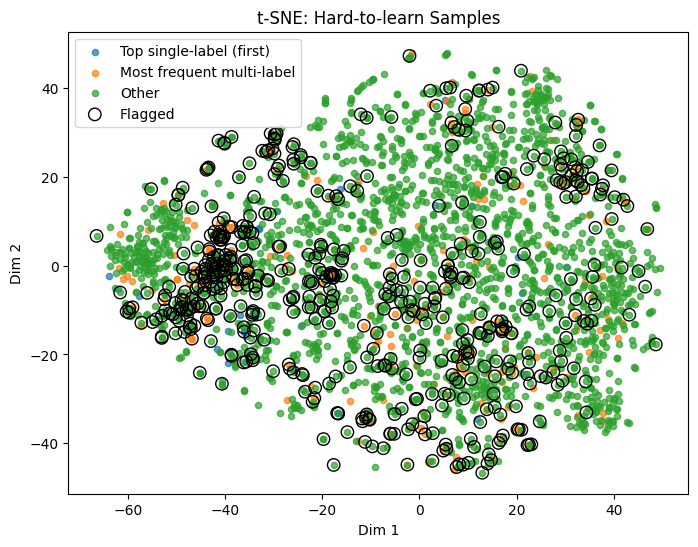

In [69]:
plot_embedding(tsne_final, "t-SNE: Hard-to-learn Samples", simple_target, legend_labels, hard_idx)



###**Outliers**

A few isolated points, far from any main cluster, were observed.

These likely represented experiments with unusual gene expression, possibly due to measurement errors or rare biological phenomena.

###**Hard-to-Learn Samples**

Regions existed where multiple colors were thoroughly mixed, indicating overlapping functional categories.

A simple classifier would likely struggle here since decision boundaries could not be drawn cleanly.

#Part C: Isomap and Manifold Learning
Isomap Implementation

- Isomap is a manifold learning technique that tries to preserve the global geometry of the data.

- Instead of Euclidean distances, it computes distances along the data manifold using nearest-neighbor graphs.

- This makes it better for showing global structure and curved manifolds in data.

- It can reveal whether the dataset lies on a highly curved surface, which helps in understanding complexity.

- Compared to t-SNE, Isomap is less about cluster visualization and more about uncovering the underlying shape of the data space.


Isomap was applied to the scaled feature matrix to obtain a 2D embedding. Unlike t-SNE, which preserves local neighborhoods, Isomap aims to preserve global geometry of the data by maintaining geodesic distances along the data manifold.

In [70]:
import numpy as np
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr

def residual_variance(X, n_neighbors, n_components=2):
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    X_trans = iso.fit_transform(X)
    # Geodesic distances from Isomap
    D_geo = iso.dist_matrix_
    # Embedded Euclidean distances
    D_embed = pairwise_distances(X_trans)
    # Compute correlation
    r, _ = pearsonr(D_geo.ravel(), D_embed.ravel())
    return 1 - r**2

for k in [5, 10, 15, 20, 25 , 30]:
    rv = residual_variance(X_scaled, n_neighbors=k)
    print(f"{k} neighbors → residual variance: {rv:.4f}")

5 neighbors → residual variance: 0.7762
10 neighbors → residual variance: 0.7724
15 neighbors → residual variance: 0.7669
20 neighbors → residual variance: 0.7657
25 neighbors → residual variance: 0.7749
30 neighbors → residual variance: 0.7790


Lower residual variance → better embedding quality (closer preservation of manifold geometry).


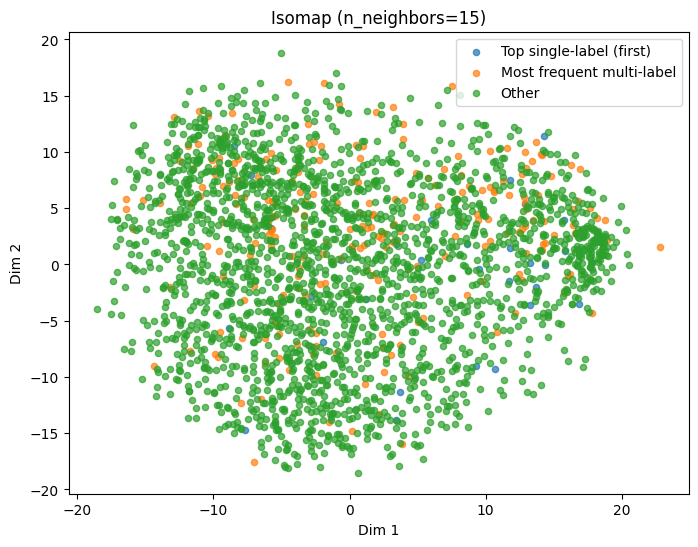

In [71]:
# ----------------------
# Part C: Isomap & Manifold Learning (20 marks)
# ----------------------

# 1. Isomap
# Why: Preserves global structure, unlike t-SNE which is more local
isomap = Isomap(n_components=2, n_neighbors=25)
iso_emb = isomap.fit_transform(X_scaled)

# 2. Visualization
plot_embedding(iso_emb, "Isomap (n_neighbors=15)", simple_target, legend_labels)





Instead of filling the entire 103-dimensional space, the yeast data occupies a structured subspace that encodes biological relationships.

From the Isomap visualization, we could observe that the points are spread along curved, elongated paths rather than forming simple flat clusters. This suggests the data manifold is highly curved and complex, which is typical for biological datasets where gene functions interact in non-linear ways.

A highly curved manifold makes classification harder because a simple linear classifier cannot separate the classes cleanly. Instead, models need to learn non-linear decision boundaries to follow the manifold’s shape. This explains why samples in overlapping or twisted regions are harder to classify, leading to hard-to-learn examples.

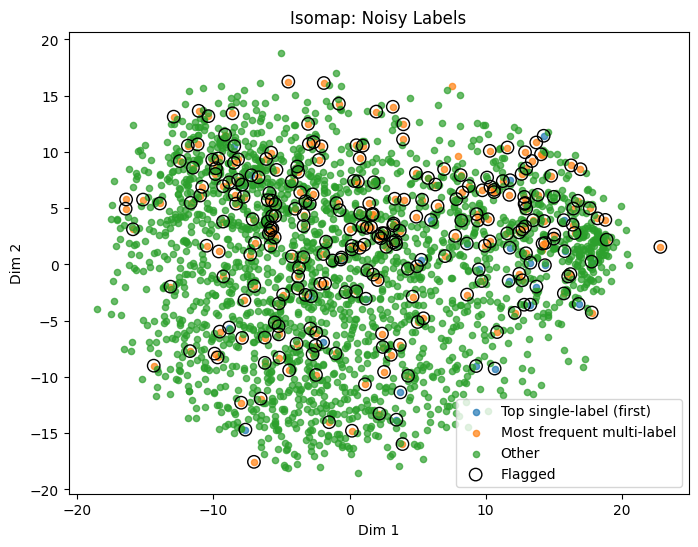

In [72]:
# Show flagged samples on Isomap
plot_embedding(iso_emb, "Isomap: Noisy Labels", simple_target, legend_labels, noisy_idx)

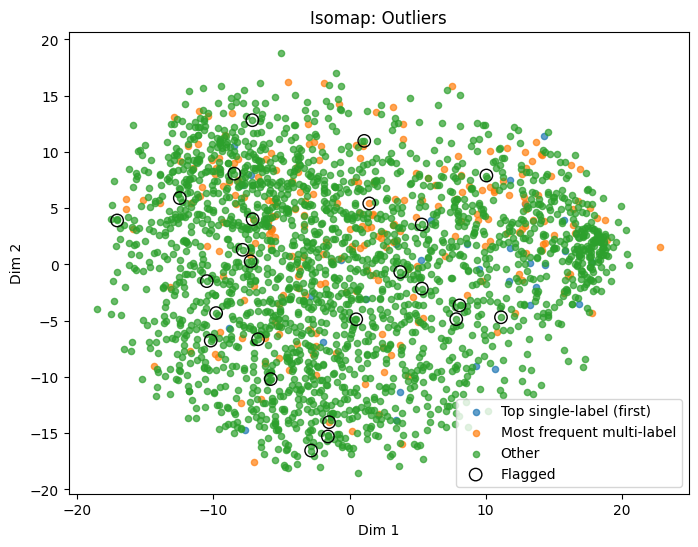

In [73]:
plot_embedding(iso_emb, "Isomap: Outliers", simple_target, legend_labels, out_idx)

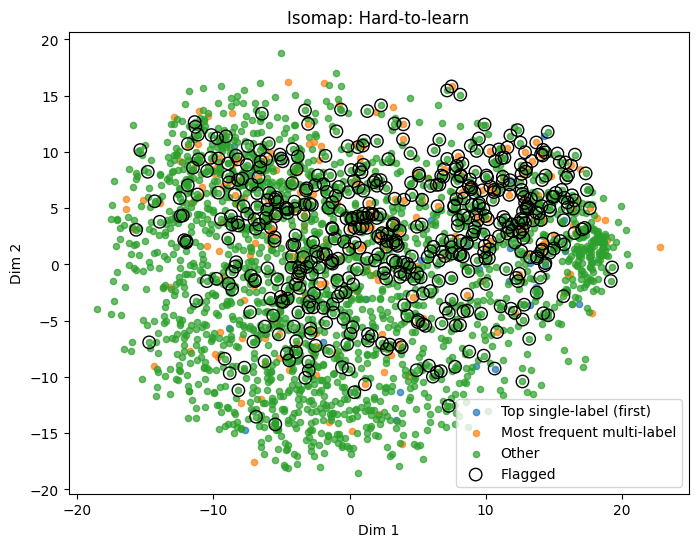

In [74]:
plot_embedding(iso_emb, "Isomap: Hard-to-learn", simple_target, legend_labels, hard_idx)

###Comparison and Curvature

t-SNE vs Isomap:

t-SNE better highlighted local anomalies such as noisy labels and mixed-category regions.

Isomap better represented the global structure, revealing how different functional clusters were connected across the manifold.

Data Manifold Complexity:

The Isomap embedding suggested that the gene expression data lay on a highly curved manifold.

This complexity implied that classification is difficult because the categories are not linearly separable. Non-linear boundaries are required to capture these relationships.

###Findings and Discussion

The study revealed several data veracity challenges in the Yeast dataset:

Noisy Labels: Overlapping clusters suggested that some genes naturally belonged to multiple categories, or that annotation errors existed.

Outliers: Isolated data points likely indicated measurement issues or rare biological cases.

Hard-to-Learn Samples: Mixed regions in both embeddings confirmed that classifiers would face difficulty distinguishing between certain functional groups.

By comparing t-SNE and Isomap, I learned that both methods provide complementary perspectives: t-SNE is useful for fine-grained inspection of local label quality, while Isomap helps in understanding the global geometry of the dataset.

#Conclusion

Through the application of t-SNE and Isomap, I visualized key data veracity issues in multi-label gene expression classification. The results emphasized that classification performance is hindered not only by algorithmic limitations but also by the intrinsic complexity of biological data, including ambiguous functions, outliers, and manifold curvature. This exercise highlighted the importance of data quality analysis before designing predictive models.